# Proyecto Hotel Booking

Este dataset contiene 119390 observaciones de un Hotel de ciudad y un Hotel Resort. Cada observación representa un reservación de hotel del 1 de Julio de 2015 al 31 de Agosto del 2017, incluyendo reservaciones que efectivamente llegaron y reservaciones que fueron canceladas.

### Objetivo

Analizar los datos para determinar la tasa de cancelación.

### Preparación de los datos 

#### Cargar datos 

In [1]:
# Cargamos todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
#Cargamos los dataset
hotel_booking = pd.read_csv('/Users/fherponce/Downloads/hotel_booking.csv',header='infer')


#### Descripción de los datos  

In [3]:
# Imprimimos información general de hotel_booking y verificamos si hay filas duplicadas
hotel_booking.info()
print(hotel_booking.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
#Mostramos el DataFrame
display(hotel_booking.head())

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


**Observaciones**
* No tenemos datos ausentes ni filas completamente duplicadas. 
* Eliminaremos las columnas que no son necesarias para este análisis

#### Limpieza de datos

In [5]:
#Crearemos un dataset solo con las columnas que nos interesan para la tasa de cancelación
hotel_booking_cancel = hotel_booking[['hotel','is_canceled','lead_time','arrival_date_year','stays_in_weekend_nights','stays_in_week_nights','meal','customer_type']]
print(hotel_booking_cancel)

               hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

        stays_in_weekend_nights  stays_in_week_nights meal customer_type  
0                             0                     0   BB     Transient  
1                             0              

El dataset tiene 36 columnas, de las cuales mantendremos sólo las necesarias. 

**hotel_booking:**
* *hotel:* Uno de los hoteles es un hotel de Ciudad y un Resort. 
* *is_canceled:* Valor que indica si la reservación es cancelada (1) o no (0).
* *lead_time:* Número de días que pasaron a partir de la fecha que se hizo la resevación en el PMS y la fecha de llegada. 
* *stays_in_weekend_nights:* Número de noches de fin de semana (sabado o domingo) el huésped se quedó o reservó en el hotel
* *stays_in_week_nights:* Número de noches entre semana (lunes a viernes) el huésped se quedó o reservó en el hotel
* *meal:* BB (Bed & Breakfast), HB(Half board), Other
* *customer_type:* Group (cuando la reserva está asociada a un grupo), Transient (cuando la reserva no es parte de un grupo o contrato), Transient-party (cuando la reserva es individual pero asociada con al menos otra reserva individual) y Other.




### Análisis exploratorio de datos

#### Identificar el número de cancelaciones según tipo de hotel

In [6]:
cancel_by_type = hotel_booking_cancel.groupby(['hotel','is_canceled'])['is_canceled'].count()
cancel_by_type = pd.DataFrame(cancel_by_type.rename('count')).reset_index()
print(cancel_by_type)

          hotel  is_canceled  count
0    City Hotel            0  46228
1    City Hotel            1  33102
2  Resort Hotel            0  28938
3  Resort Hotel            1  11122


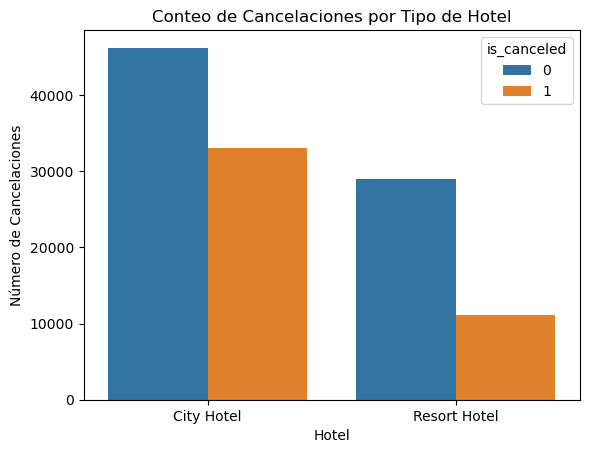

In [7]:
# Crear el gráfico de barras
cancel_by_type['is_canceled'] = cancel_by_type['is_canceled'].astype(str)
sns.barplot(data=cancel_by_type, x='hotel', y='count', hue='is_canceled')

# Títulos y etiquetas
plt.title('Conteo de Cancelaciones por Tipo de Hotel')
plt.xlabel('Hotel')
plt.ylabel('Número de Cancelaciones')

# Mostrar el gráfico
plt.show()

**Observaciones**
* Tenemos un 66.44% de reservaciones en hotel de ciudad, y 33.55% en un Resort.
* El 41.72% de las reservaciones de hotel de Ciudad fueron canceladas
* El 27.26% de las reservaciones a un Resort fueron canceladas
